In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd
from cuml.manifold.umap import UMAP as cumlUMAP
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### load data

In [3]:
DATASET_ID = 'buckeye'
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'phones.pickle'

In [4]:
syllable_df = pd.read_pickle(df_loc)
del syllable_df['audio']

In [5]:
syllable_df[:3]

,start_time,end_time,labels,word,utterance_number,position_in_utterance,position_in_word,word_number,indv,indvi,age,sex,key,rate,spectrogram
0,4.885333,4.988600,w,well,0,0,0,0,s07,0,o,f,s0702b,16000,"[[2, 2, 2, 2, 0, 44, 79, 95, 86, 81, 77, 38, 3..."
1,4.988600,5.114649,eh,well,1,0,1,0,s07,0,o,f,s0702b,16000,"[[4, 4, 174, 166, 164, 162, 160, 159, 159, 161..."
2,5.114649,5.255262,l,well,2,0,2,0,s07,0,o,f,s0702b,16000,"[[5, 5, 170, 156, 156, 154, 151, 149, 147, 144..."


In [6]:
np.shape(syllable_df.spectrogram.values[0])

(32, 24)

### project

(27999, 768)


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


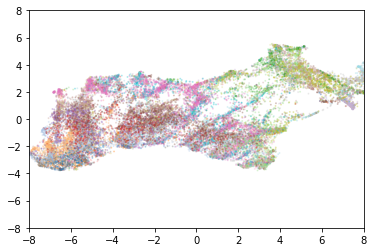

(20732, 768)


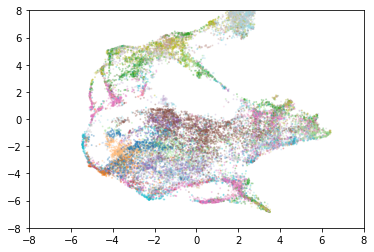

(10639, 768)


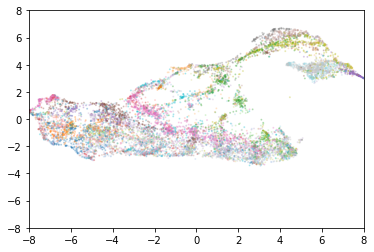

(17378, 768)


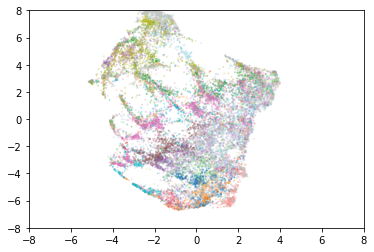

(19219, 768)


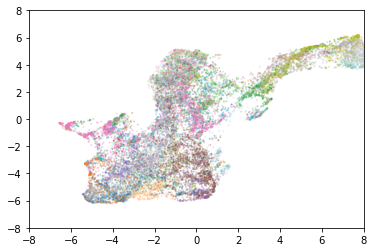

(18324, 768)


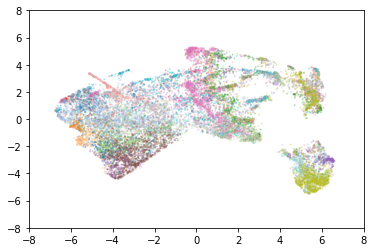

(13259, 768)


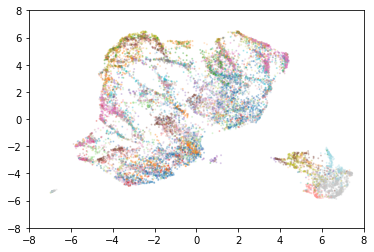

(19630, 768)


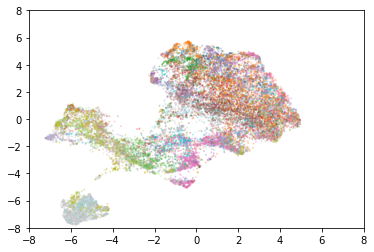

(20053, 768)


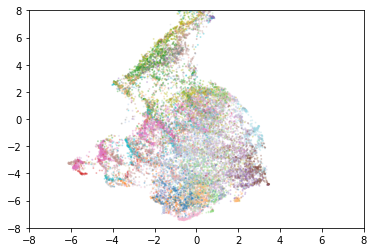

(9141, 768)


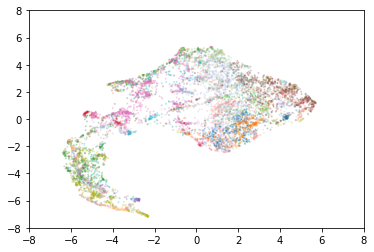

(25189, 768)


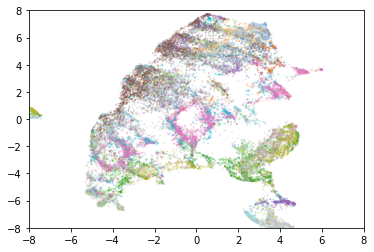

(22728, 768)


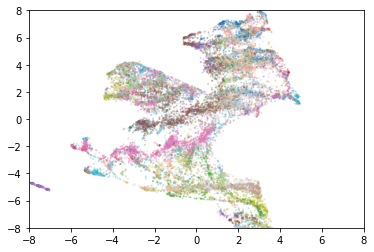

(13973, 768)


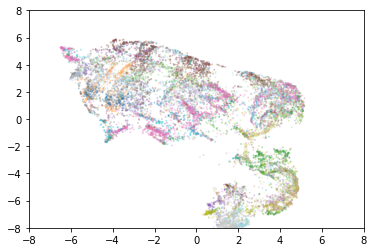

(20589, 768)


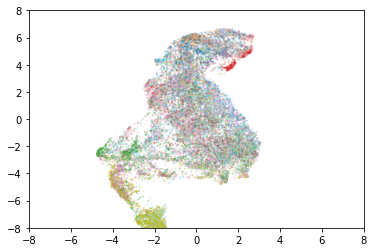

(23632, 768)


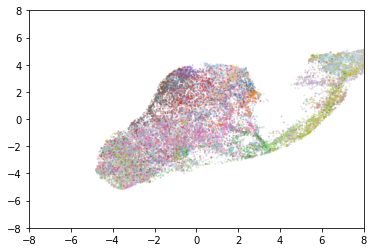

(16345, 768)


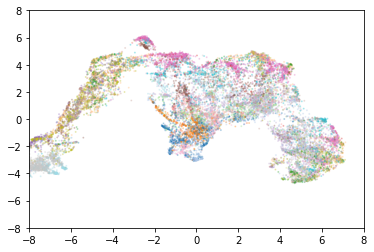

(20711, 768)


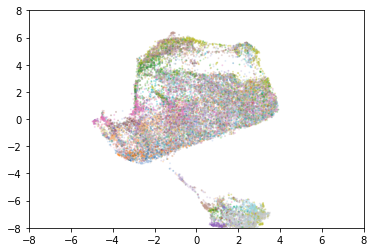

(14523, 768)


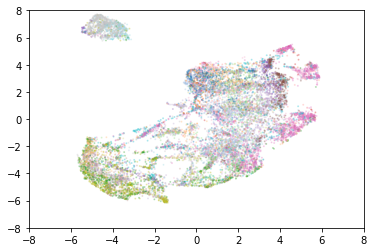

(19108, 768)


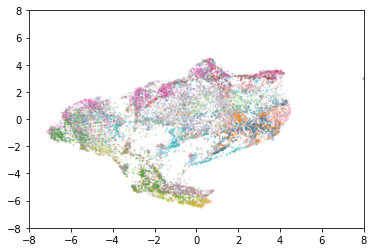

(16792, 768)


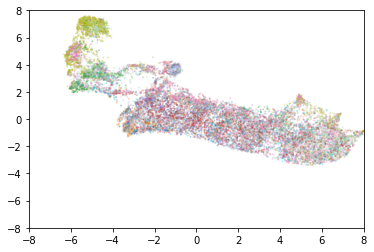

(20853, 768)


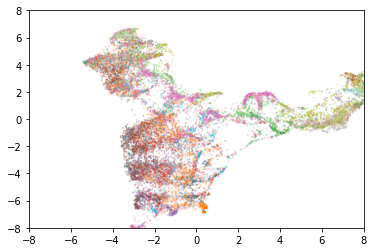

(34800, 768)


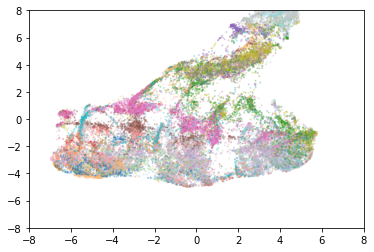

(27160, 768)


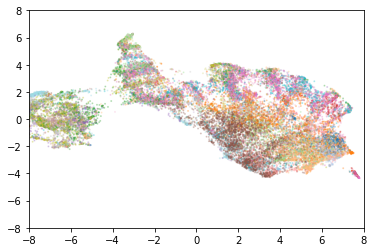

(20583, 768)


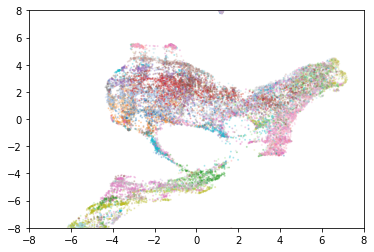

(20773, 768)


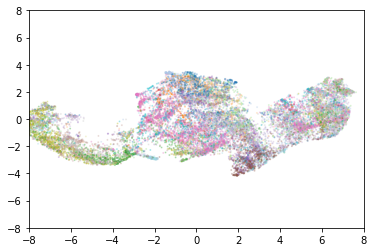

(24764, 768)


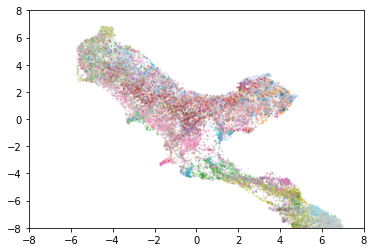

(31905, 768)


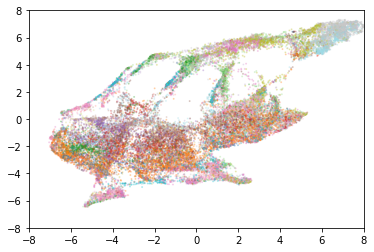

(26858, 768)


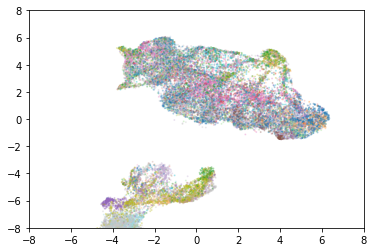

(14767, 768)


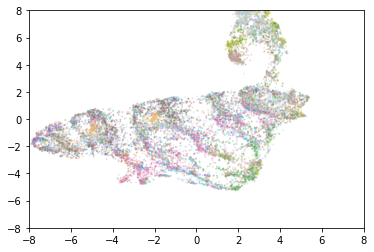

(17186, 768)


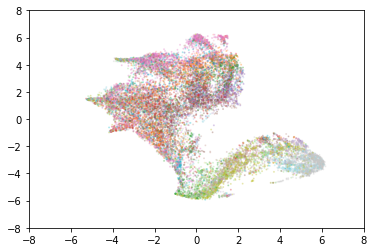

(17663, 768)


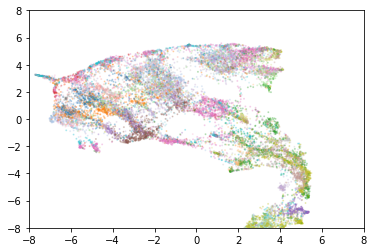

(15740, 768)


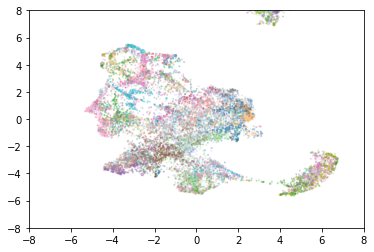

(27202, 768)


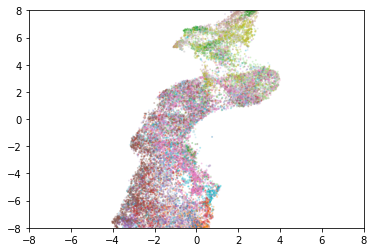

(31600, 768)


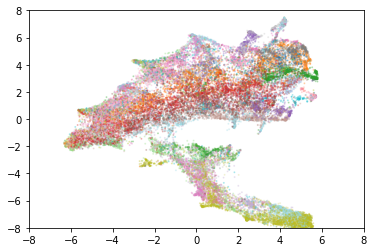

(26111, 768)


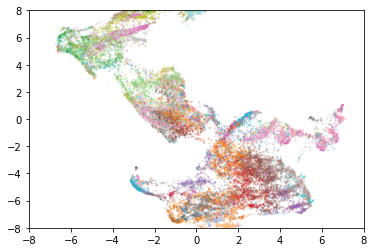

(22734, 768)


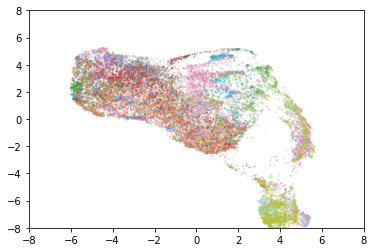

(21838, 768)


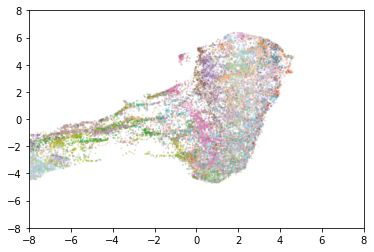

(15275, 768)


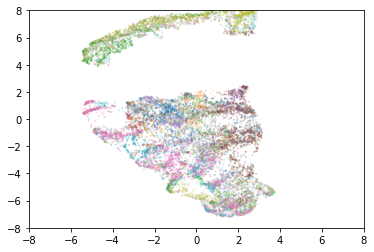

(22251, 768)


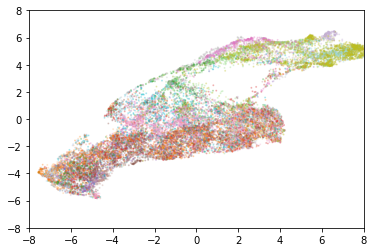

(27180, 768)


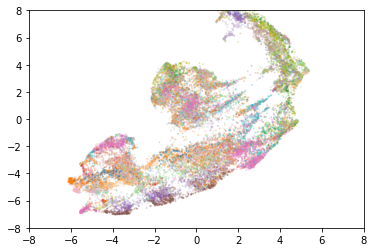

In [18]:
for indv in tqdm(syllable_df.indv.unique()):
    subset_df = syllable_df[syllable_df.indv == indv]
    
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in tqdm(specs)]
    specs_flattened = flatten_spectrograms(specs)
    print(np.shape(specs_flattened))
    
    cuml_umap = cumlUMAP()
    embedding = cuml_umap.fit_transform(specs_flattened)
    subset_df['umap'] = list(embedding)
    
    unique_labs = np.unique(subset_df.labels.values)
    unique_labs_dict = {lab:i for i, lab in enumerate(unique_labs)}
    lab_list = [unique_labs_dict[i] for i in subset_df.labels.values]
    fig, ax = plt.subplots()
    ax.scatter(embedding[:,0], embedding[:,1], s=1, c=lab_list, cmap=plt.cm.tab20, alpha = 0.25)
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    plt.show()
    
    ensure_dir(DATA_DIR / 'embeddings' / DATASET_ID / 'indvs')
    subset_df.to_pickle(DATA_DIR / 'embeddings' / DATASET_ID / 'indvs' / (indv + '.pickle'))